## PDFs of echo top height

In [169]:
from matplotlib import pyplot as plt
from netCDF4 import Dataset
%matplotlib inline
from datetime import datetime, timedelta
import numpy as np
from scipy import optimize, stats
from scipy.signal import argrelextrema
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [170]:
hist1_path = '/home/rjackson/data/echo_top_histograms1_hour.cdf'
hist2_path = '/home/rjackson/data/echo_top_histograms2_hour.cdf'
height_bins = np.arange(0, 20000, 500)
hist1_file = Dataset(hist1_path, mode='r')
hist2_file = Dataset(hist2_path, mode='r')
hist_break = hist2_file.variables['hist_break'][:]
hist_monsoon = hist2_file.variables['hist_monsoon'][:]
hist_total = hist2_file.variables['hist_total'][:]
hist_break = np.sum(hist_break, axis=2)
hist_monsoon = np.sum(hist_monsoon, axis=2)
hist_total = np.sum(hist_total, axis=2)
hist_break[0,:] = 0
hist_monsoon[0,:] = 0
hist_total[0,:] = 0
b_inds = argrelextrema(hist_break, np.greater)
m_inds = argrelextrema(hist_monsoon, np.greater)
print(hist_break.shape)
print(height_bins.shape)

(39, 8)
(40,)


(0, 0.1)

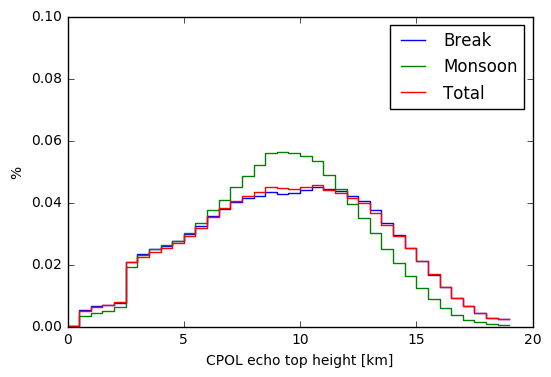

In [11]:
plt.step(height_bins[:-1]/1e3, np.sum(hist_break[:,:], axis=1)/np.sum(hist_break))
plt.step(height_bins[:-1]/1e3, np.sum(hist_monsoon[:,:], axis=1)/np.sum(hist_monsoon))
plt.step(height_bins[:-1]/1e3, np.sum(hist_total[:,:], axis=1)/np.sum(hist_total))
#plt.scatter(height_bins[b_inds[0]]/1e3, np.sum(hist_break[b_inds[0],:], axis=1)/np.sum(hist_break))
#plt.scatter(height_bins[m_inds[0]]/1e3, np.sum(hist_monsoon[m_inds[0],:], axis=1)/np.sum(hist_monsoon))
plt.legend(['Break', 'Monsoon', 'Total'])
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.xlim([0, 20])
plt.ylim([0, 0.10])

## Do multigaussian fits

In [4]:
def gaussian(x, center, width):
    return np.exp(-(x - center)**2/(2*width**2)) / (width*np.sqrt(2*np.pi))

def two_gaussians(x, c1, w1, c2, w2, A):
    return (A * gaussian(x, c1, w1) +
           (1 - A) * gaussian(x, c2, w2)) 

def three_gaussians(x, c1, w1, c2, w2, c3, w3, A, B):
    return (A * gaussian(x, c1, w1) +
            B * gaussian(x, c2, w2) + 
            (1 - A - B) * gaussian(x, c3, w3)) 
    
    
errfunc = lambda p, x, y: (two_gaussians(x, *p) - y)**2
errfunc3 = lambda p, x, y: (three_gaussians(x, *p) - y)**2

guess = [5, 1, 10, 1, 0.5]
guess3 = [5, 1, 10, 1, 15, 1, 0.3, 0.3]

fits_break3 = np.zeros((8, 8))
fits_monsoon3 = np.zeros((8, 8))
fits_total3 = np.zeros((8, 8))
fits_break2 = np.zeros((5, 8))
fits_monsoon2 = np.zeros((5, 8))
fits_total2 = np.zeros((5, 8))
chisquare_break3 = np.zeros(8)
chisquare_monsoon3 = np.zeros(8)
chisquare_break2 = np.zeros(8)
chisquare_monsoon2 = np.zeros(8)


for mjo_indicies in range(8):
    break_sum = np.sum(hist_break[:, mjo_indicies])/2
    monsoon_sum = np.sum(hist_monsoon[:, mjo_indicies])/2
    total_sum = np.sum(hist_total[:, mjo_indicies])/2
    fits_break3[:,mjo_indicies], success = optimize.curve_fit(three_gaussians, p0=guess3[:], 
                                                              xdata=height_bins[:-1]/1e3, 
                                                              ydata=hist_break[:, mjo_indicies]/break_sum,
                                                              bounds=(0,20))
    fexp = three_gaussians(height_bins[:-1]/1e3, *fits_break3[:,mjo_indicies])
    stat, p = stats.chisquare(hist_break[:,mjo_indicies]/break_sum, fexp)
    chisquare_break3[mjo_indicies] = p
    fits_monsoon3[:,mjo_indicies], success = optimize.curve_fit(three_gaussians, p0=guess3[:], 
                                                                xdata=height_bins[:-1]/1e3, 
                                                                ydata=hist_monsoon[:,mjo_indicies]/monsoon_sum,
                                                                bounds=(0,20))
    fexp = three_gaussians(height_bins[:-1]/1e3, *fits_monsoon3[:,mjo_indicies])
    stat, p = stats.chisquare(hist_monsoon[:,mjo_indicies]/monsoon_sum, fexp)
    chisquare_monsoon3[mjo_indicies] = p
    fits_total3[:,mjo_indicies], success = optimize.curve_fit(three_gaussians, p0=guess3[:], 
                                                              xdata=height_bins[:-1]/1e3, 
                                                              ydata=(hist_total[:,mjo_indicies])/(total_sum),
                                                              bounds=(0,20))
    fexp = three_gaussians(height_bins[:-1]/1e3, *fits_total3[:,mjo_indicies])
    stat, p = stats.chisquare(hist_total[:,mjo_indicies]/monsoon_sum, fexp)

    
    fits_break2[:,mjo_indicies], success = optimize.curve_fit(two_gaussians, p0=guess[:], 
                                                              xdata=height_bins[:-1]/1e3, 
                                                              ydata=hist_break[:,mjo_indicies]/break_sum,
                                                              bounds=(0,20))
    fexp = two_gaussians(height_bins[:-1]/1e3, *fits_break2[:,mjo_indicies])
    stat, p = stats.chisquare(hist_break[:,mjo_indicies]/monsoon_sum, fexp)
    chisquare_break2[mjo_indicies] = p
    fits_monsoon2[:,mjo_indicies], success = optimize.curve_fit(two_gaussians, p0=guess[:], 
                                                                xdata=height_bins[:-1]/1e3, 
                                                                ydata=hist_monsoon[:,mjo_indicies]/monsoon_sum,
                                                                bounds=(0,20))
    fexp = two_gaussians(height_bins[:-1]/1e3, *fits_monsoon2[:,mjo_indicies])
    stat, p = stats.chisquare(hist_monsoon[:,mjo_indicies]/monsoon_sum, fexp)
    chisquare_monsoon2[mjo_indicies] = p
    fits_total2[:,mjo_indicies], success = optimize.curve_fit(two_gaussians, p0=guess[:], 
                                                                xdata=height_bins[:-1]/1e3, 
                                                                ydata=hist_total[:,mjo_indicies]/total_sum,
                                                                bounds=(0,20))
    fexp = two_gaussians(height_bins[:-1]/1e3, *fits_total2[:,mjo_indicies])
    

ValueError: operands could not be broadcast together with shapes (39,) (39,24) 

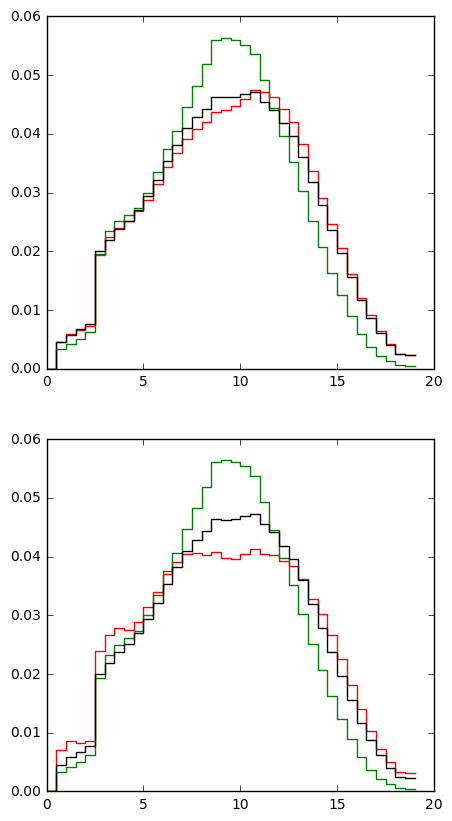

In [13]:
hist_break_mjo_aust = np.sum(hist_break[:, 3:7], axis=1)
hist_monsoon_mjo_aust = np.sum(hist_monsoon[:, 3:7], axis=1)
hist_total_mjo_aust = np.sum(hist_total[:, 3:7], axis=1)
hist_break_mjo_noaust = np.sum(hist_break[:, 1:3], axis=1) + hist_break[:,7]
hist_monsoon_mjo_noaust = np.sum(hist_monsoon[:, 3:7], axis=1) + hist_monsoon[:,7]
hist_total_mjo_noaust = np.sum(hist_total[:, 3:7], axis=1) + hist_monsoon[:,7]

plt.figure(figsize=(5,10))
plt.subplot(211)
plt.step(height_bins[:-1]/1e3, hist_break_mjo_aust/np.sum(hist_break_mjo_aust), color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon_mjo_aust/np.sum(hist_monsoon_mjo_aust), color='g')
plt.step(height_bins[:-1]/1e3, hist_total_mjo_aust/np.sum(hist_total_mjo_aust), color='k')

plt.subplot(212)
plt.step(height_bins[:-1]/1e3, hist_break_mjo_noaust/np.sum(hist_break_mjo_noaust), color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon_mjo_noaust/np.sum(hist_monsoon_mjo_noaust), color='g')
plt.step(height_bins[:-1]/1e3, hist_total_mjo_noaust/np.sum(hist_total_mjo_noaust), color='k')

In [65]:
plt.figure(figsize=(6,6))
print(chisquare_break3)
print(chisquare_monsoon3)
print(chisquare_break2)
print(chisquare_monsoon2)

[ 1.  1.  1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.  1.  1.]
[  4.00181857e-17   9.11334092e-35   3.61008631e-08   7.78488470e-04
   9.99965995e-01   9.98749365e-01   9.99999968e-01   0.00000000e+00]
[ 1.  1.  1.  1.  1.  1.  1.  1.]


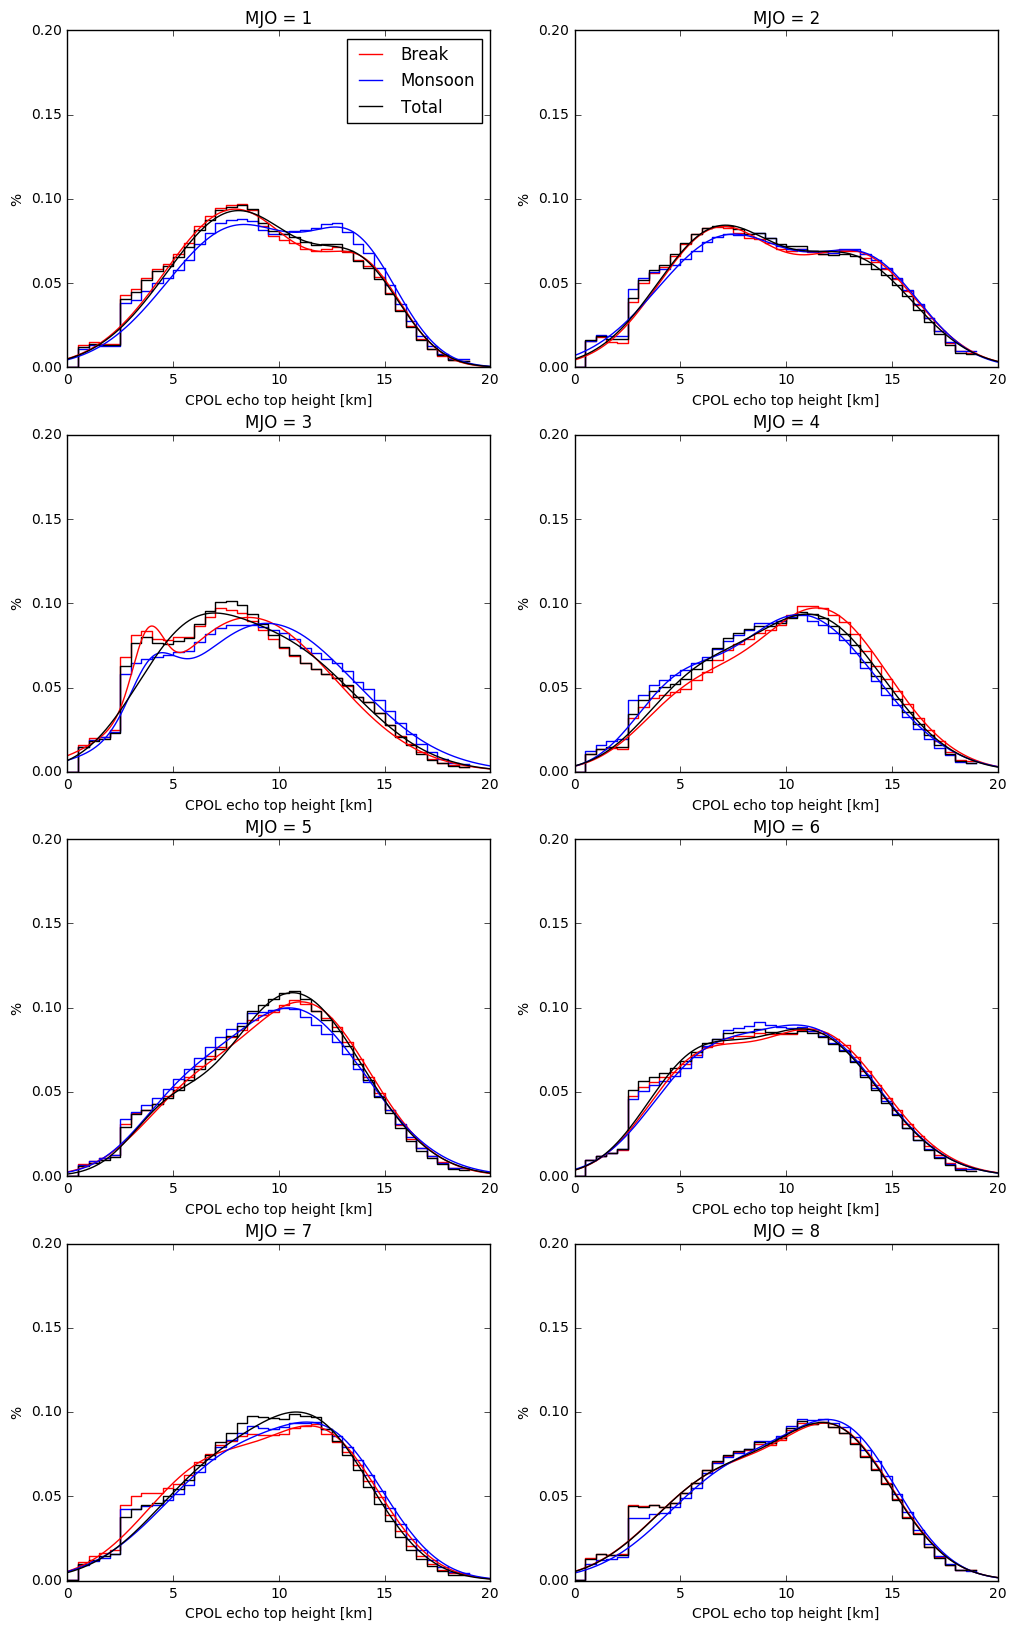

In [98]:
x_curve = np.arange(0, 20, 0.01)
plt.figure(figsize=(12,20))
plt.subplot(421)
plt.step(height_bins[:-1]/1e3, hist_break[:,0]/np.sum(hist_break[:,0])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,0]/np.sum(hist_monsoon[:,0])*2, color='b')
plt.step(height_bins[:-1]/1e3, hist_total[:,0]/np.sum(hist_total[:,0])*2, color='k')
plt.plot(x_curve, two_gaussians(x_curve, *fits_break2[:,0]), color='r')
plt.plot(x_curve, two_gaussians(x_curve, *fits_monsoon2[:,0]), color='b')
plt.plot(x_curve, two_gaussians(x_curve, *fits_total2[:,0]), color='k')
plt.legend(['Break', 'Monsoon', 'Total'])
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.2])
plt.title('MJO = 1')
plt.subplot(422)
plt.step(height_bins[:-1]/1e3, hist_break[:,1]/np.sum(hist_break[:,1])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,1]/np.sum(hist_monsoon[:,1])*2, color='b')
plt.step(height_bins[:-1]/1e3, hist_total[:,1]/np.sum(hist_total[:,1])*2, color='k')
plt.plot(x_curve, two_gaussians(x_curve, *fits_break2[:,1]), color='r')
plt.plot(x_curve, two_gaussians(x_curve, *fits_monsoon2[:,1]), color='b')
plt.plot(x_curve, two_gaussians(x_curve, *fits_total2[:,1]), color='k')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.2])
plt.title('MJO = 2')
plt.subplot(423)
plt.step(height_bins[:-1]/1e3, hist_break[:,2]/np.sum(hist_break[:,2])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,2]/np.sum(hist_monsoon[:,2])*2, color='b')
plt.step(height_bins[:-1]/1e3, hist_total[:,2]/np.sum(hist_total[:,2])*2, color='k')
plt.plot(x_curve, two_gaussians(x_curve, *fits_break2[:,2]), color='r')
plt.plot(x_curve, two_gaussians(x_curve, *fits_monsoon2[:,2]), color='b')
plt.plot(x_curve, two_gaussians(x_curve, *fits_total2[:,2]), color='k')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.2])
plt.title('MJO = 3')
plt.subplot(424)
plt.step(height_bins[:-1]/1e3, hist_break[:,3]/np.sum(hist_break[:,3])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,3]/np.sum(hist_monsoon[:,3])*2, color='b')
plt.step(height_bins[:-1]/1e3, hist_total[:,3]/np.sum(hist_total[:,3])*2, color='k')
plt.plot(x_curve, two_gaussians(x_curve, *fits_break2[:,3]), color='r')
plt.plot(x_curve, two_gaussians(x_curve, *fits_monsoon2[:,3]), color='b')
plt.plot(x_curve, two_gaussians(x_curve, *fits_total2[:,3]), color='k')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.2])
plt.title('MJO = 4')
plt.subplot(425)
plt.step(height_bins[:-1]/1e3, hist_break[:,4]/np.sum(hist_break[:,4])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,4]/np.sum(hist_monsoon[:,4])*2, color='b')
plt.step(height_bins[:-1]/1e3, hist_total[:,4]/np.sum(hist_total[:,4])*2, color='k')
plt.plot(x_curve, two_gaussians(x_curve, *fits_break2[:,4]), color='r')
plt.plot(x_curve, two_gaussians(x_curve, *fits_monsoon2[:,4]), color='b')
plt.plot(x_curve, two_gaussians(x_curve, *fits_total2[:,4]), color='k')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.2])
plt.title('MJO = 5')
plt.subplot(426)
plt.step(height_bins[:-1]/1e3, hist_break[:,5]/np.sum(hist_break[:,5])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,5]/np.sum(hist_monsoon[:,5])*2, color='b')
plt.step(height_bins[:-1]/1e3, hist_total[:,5]/np.sum(hist_total[:,5])*2, color='k')
plt.plot(x_curve, two_gaussians(x_curve, *fits_break2[:,5]), color='r')
plt.plot(x_curve, two_gaussians(x_curve, *fits_monsoon2[:,5]), color='b')
plt.plot(x_curve, two_gaussians(x_curve, *fits_total2[:,5]), color='k')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.2])
plt.title('MJO = 6')
plt.subplot(427)
plt.step(height_bins[:-1]/1e3, hist_break[:,6]/np.sum(hist_break[:,6])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,6]/np.sum(hist_monsoon[:,6])*2, color='b')
plt.step(height_bins[:-1]/1e3, hist_total[:,6]/np.sum(hist_total[:,6])*2, color='k')
plt.plot(x_curve, two_gaussians(x_curve, *fits_break2[:,6]), color='r')
plt.plot(x_curve, two_gaussians(x_curve, *fits_monsoon2[:,6]), color='b')
plt.plot(x_curve, two_gaussians(x_curve, *fits_total2[:,6]), color='k')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.2])
plt.title('MJO = 7')
plt.subplot(428)
plt.step(height_bins[:-1]/1e3, hist_break[:,7]/np.sum(hist_break[:,7])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,7]/np.sum(hist_monsoon[:,7])*2, color='b')
plt.step(height_bins[:-1]/1e3, hist_total[:,7]/np.sum(hist_total[:,7])*2, color='k')
plt.plot(x_curve, two_gaussians(x_curve, *fits_break2[:,7]), color='r')
plt.plot(x_curve, two_gaussians(x_curve, *fits_monsoon2[:,7]), color='b')
plt.plot(x_curve, two_gaussians(x_curve, *fits_total2[:,7]), color='k')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.2])
plt.title('MJO = 8')

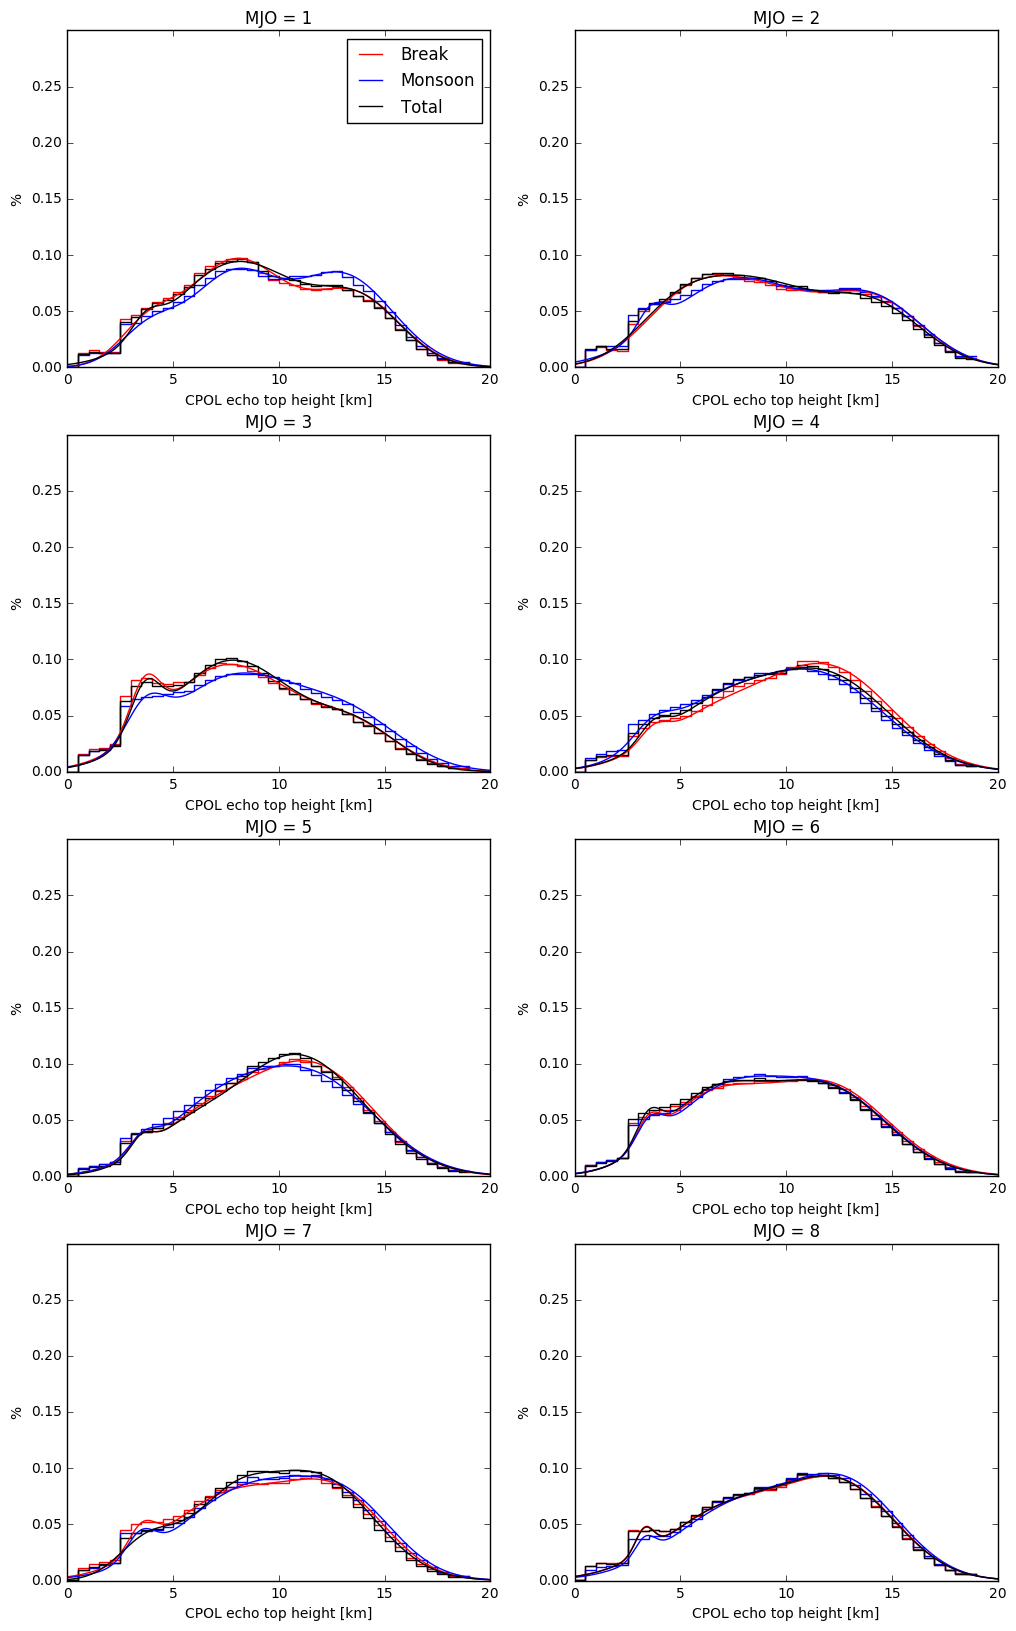

In [109]:
x_curve = np.arange(0, 20, 0.01)
plt.figure(figsize=(12,20))
plt.subplot(421)
plt.step(height_bins[:-1]/1e3, hist_break[:,0]/np.sum(hist_break[:,0])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,0]/np.sum(hist_monsoon[:,0])*2, color='b')
plt.step(height_bins[:-1]/1e3, hist_total[:,0]/np.sum(hist_total[:,0])*2, color='k')
plt.plot(x_curve, three_gaussians(x_curve, *fits_break3[:,0]), color='r')
plt.plot(x_curve, three_gaussians(x_curve, *fits_monsoon3[:,0]), color='b')
plt.plot(x_curve, three_gaussians(x_curve, *fits_total3[:,0]), color='k')
plt.legend(['Break', 'Monsoon', 'Total'])
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.3])
plt.title('MJO = 1')
plt.subplot(422)
plt.step(height_bins[:-1]/1e3, hist_break[:,1]/np.sum(hist_break[:,1])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,1]/np.sum(hist_monsoon[:,1])*2, color='b')
plt.step(height_bins[:-1]/1e3, hist_total[:,1]/np.sum(hist_total[:,1])*2, color='k')
plt.plot(x_curve, three_gaussians(x_curve, *fits_break3[:,1]), color='r')
plt.plot(x_curve, three_gaussians(x_curve, *fits_monsoon3[:,1]), color='b')
plt.plot(x_curve, three_gaussians(x_curve, *fits_total3[:,1]), color='k')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.3])
plt.title('MJO = 2')
plt.subplot(423)
plt.step(height_bins[:-1]/1e3, hist_break[:,2]/np.sum(hist_break[:,2])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,2]/np.sum(hist_monsoon[:,2])*2, color='b')
plt.step(height_bins[:-1]/1e3, hist_total[:,2]/np.sum(hist_total[:,2])*2, color='k')
plt.plot(x_curve, three_gaussians(x_curve, *fits_break3[:,2]), color='r')
plt.plot(x_curve, three_gaussians(x_curve, *fits_monsoon3[:,2]), color='b')
plt.plot(x_curve, three_gaussians(x_curve, *fits_total3[:,2]), color='k')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.3])
plt.title('MJO = 3')
plt.subplot(424)
plt.step(height_bins[:-1]/1e3, hist_break[:,3]/np.sum(hist_break[:,3])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,3]/np.sum(hist_monsoon[:,3])*2, color='b')
plt.step(height_bins[:-1]/1e3, hist_total[:,3]/np.sum(hist_total[:,3])*2, color='k')
plt.plot(x_curve, three_gaussians(x_curve, *fits_break3[:,3]), color='r')
plt.plot(x_curve, three_gaussians(x_curve, *fits_monsoon3[:,3]), color='b')
plt.plot(x_curve, three_gaussians(x_curve, *fits_total3[:,3]), color='k')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.3])
plt.title('MJO = 4')
plt.subplot(425)
plt.step(height_bins[:-1]/1e3, hist_break[:,4]/np.sum(hist_break[:,4])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,4]/np.sum(hist_monsoon[:,4])*2, color='b')
plt.step(height_bins[:-1]/1e3, hist_total[:,4]/np.sum(hist_total[:,4])*2, color='k')
plt.plot(x_curve, three_gaussians(x_curve, *fits_break3[:,4]), color='r')
plt.plot(x_curve, three_gaussians(x_curve, *fits_monsoon3[:,4]), color='b')
plt.plot(x_curve, three_gaussians(x_curve, *fits_total3[:,4]), color='k')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.3])
plt.title('MJO = 5')
plt.subplot(426)
plt.step(height_bins[:-1]/1e3, hist_break[:,5]/np.sum(hist_break[:,5])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,5]/np.sum(hist_monsoon[:,5])*2, color='b')
plt.step(height_bins[:-1]/1e3, hist_total[:,5]/np.sum(hist_total[:,5])*2, color='k')
plt.plot(x_curve, three_gaussians(x_curve, *fits_break3[:,5]), color='r')
plt.plot(x_curve, three_gaussians(x_curve, *fits_monsoon3[:,5]), color='b')
plt.plot(x_curve, three_gaussians(x_curve, *fits_total3[:,5]), color='k')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.3])
plt.title('MJO = 6')
plt.subplot(427)
plt.step(height_bins[:-1]/1e3, hist_break[:,6]/np.sum(hist_break[:,6])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,6]/np.sum(hist_monsoon[:,6])*2, color='b')
plt.step(height_bins[:-1]/1e3, hist_total[:,6]/np.sum(hist_total[:,6])*2, color='k')
plt.plot(x_curve, three_gaussians(x_curve, *fits_break3[:,6]), color='r')
plt.plot(x_curve, three_gaussians(x_curve, *fits_monsoon3[:,6]), color='b')
plt.plot(x_curve, three_gaussians(x_curve, *fits_total3[:,6]), color='k')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.3])
plt.title('MJO = 7')
plt.subplot(428)
plt.step(height_bins[:-1]/1e3, hist_break[:,7]/np.sum(hist_break[:,7])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,7]/np.sum(hist_monsoon[:,7])*2, color='b')
plt.step(height_bins[:-1]/1e3, hist_total[:,7]/np.sum(hist_total[:,7])*2, color='k')
plt.plot(x_curve, three_gaussians(x_curve, *fits_break3[:,7]), color='r')
plt.plot(x_curve, three_gaussians(x_curve, *fits_monsoon3[:,7]), color='b')
plt.plot(x_curve, three_gaussians(x_curve, *fits_total3[:,7]), color='k')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.3])
plt.title('MJO = 8')

In [54]:
from scipy import interpolate
def calc_percentile_from_hist(hist, bins, percent):
    cdf = np.cumsum(hist)/np.sum(hist)*100
    cdf_func = interpolate.interp1d(cdf, bins)
    return cdf_func(percent)

/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


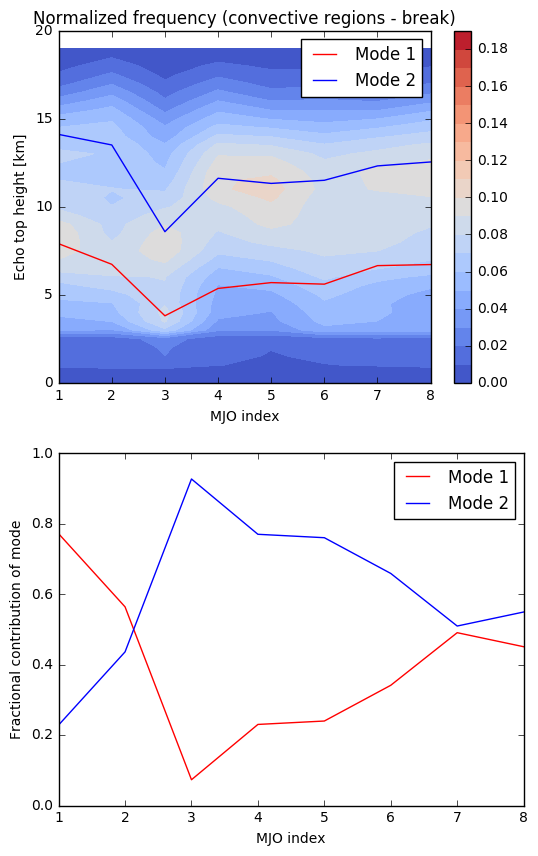

In [89]:
hist_mjo = hist_break
mjos_2d, bins_2d = np.meshgrid(np.arange(1,9), height_bins[:-1]/1e3)
# Calculate percentiles
five = np.zeros(8)
fifty = np.zeros(8)
ninety_five = np.zeros(8)
for mjo_index in range(0,8):
    five[mjo_index] = calc_percentile_from_hist(hist_mjo[:,mjo_index],
                                                height_bins[:-1]/1e3,
                                                5)
    fifty[mjo_index] = calc_percentile_from_hist(hist_mjo[:,mjo_index],
                                                 height_bins[:-1]/1e3,
                                                 50)
    ninety_five[mjo_index] = calc_percentile_from_hist(hist_mjo[:,mjo_index],
                                                       height_bins[:-1]/1e3,
                                                       95)
plt.figure(figsize=(6,10))
plt.subplot(211)   
plt.contourf(mjos_2d, bins_2d, hist_mjo/np.sum(hist_mjo, axis=0)*2,
             cmap='coolwarm', levels=np.arange(0,0.2,0.01))
#plt.plot(np.arange(1,9), five, color = 'k', linestyle='--')
plt.plot(np.arange(1,9), fits_break2[0,:], color = 'r', linestyle='-', label="Mode 1")
plt.plot(np.arange(1,9), fits_break2[2,:], color = 'b', linestyle='-', label="Mode 2")
#plt.plot(np.arange(1,9), fits_break2[4,:], color = 'b', linestyle='-', label="3")
plt.legend()
plt.ylim([0,20])
#plt.plot(np.arange(1,9), ninety_five, color = 'k', linestyle='--')
plt.xlabel('MJO index')
plt.ylabel('Echo top height [km]')
plt.title('Normalized frequency (convective regions - break)')
ax = plt.colorbar()
plt.subplot(212)
plt.plot(np.arange(1,9), fits_break2[4,:], label="Mode 1", color='r')
plt.plot(np.arange(1,9), 1-fits_break2[4,:], label="Mode 2", color='b')
#plt.plot(np.arange(1,9), 1-np.sum(fits_break2[6:8,:], axis=0), label="Deep", color= 'b')
plt.xlabel('MJO index')
plt.ylabel('Fractional contribution of mode')
plt.ylim([0, 1])
plt.legend(loc='best')

/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


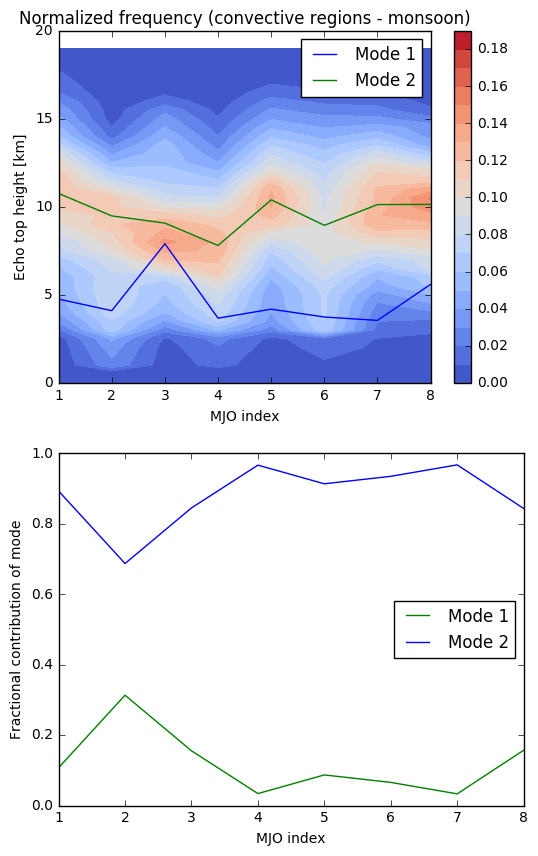

In [18]:
hist_mjo = hist_monsoon
mjos_2d, bins_2d = np.meshgrid(np.arange(1,9), height_bins[:-1]/1e3)
five = np.zeros(8)
fifty = np.zeros(8)
ninety_five = np.zeros(8)
for mjo_index in range(0,8):
    five[mjo_index] = calc_percentile_from_hist(hist_monsoon[:,mjo_index],
                                                height_bins[:-1]/1e3,
                                                5)
    fifty[mjo_index] = calc_percentile_from_hist(hist_monsoon[:,mjo_index],
                                                 height_bins[:-1]/1e3,
                                                 50)
    ninety_five[mjo_index] = calc_percentile_from_hist(hist_monsoon[:,mjo_index],
                                                       height_bins[:-1]/1e3,
                                                       95)
plt.figure(figsize=(6,10))
plt.subplot(211)
plt.contourf(mjos_2d, bins_2d, hist_monsoon/np.sum(hist_monsoon, axis=0)*2,
             cmap='coolwarm', levels=np.arange(0,0.2,0.01))
#plt.plot(np.arange(1,9), five, color = 'k', linestyle='--')
#plt.plot(np.arange(1,9), fifty, color = 'k', linestyle='-')
#plt.plot(np.arange(1,9), ninety_five, color = 'k', linestyle='--')

plt.plot(np.arange(1,9), fits_monsoon2[0,:], color='b', linestyle='-', label="Mode 1")
plt.plot(np.arange(1,9), fits_monsoon2[2,:], color='g', linestyle='-', label="Mode 2")
#plt.plot(np.arange(1,9), fits_monsoon3[4,:], color='b', linestyle='-', label="3")
plt.legend(loc='best')
plt.xlabel('MJO index')
plt.ylabel('Echo top height [km]')
plt.ylim([0,20])
plt.title('Normalized frequency (convective regions - monsoon)')
ax = plt.colorbar()
plt.subplot(212)
plt.plot(np.arange(1,9), fits_monsoon2[4,:], label="Mode 1", color='g')
plt.plot(np.arange(1,9), 1-fits_monsoon2[4,:], label="Mode 2", color='b')
#plt.plot(np.arange(1,9), 1-np.sum(fits_monsoon3[6:8,:], axis=0), label="Deep", color='b')
plt.xlabel('MJO index')
plt.ylabel('Fractional contribution of mode')
plt.ylim([0, 1])
plt.legend(loc='best')

/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


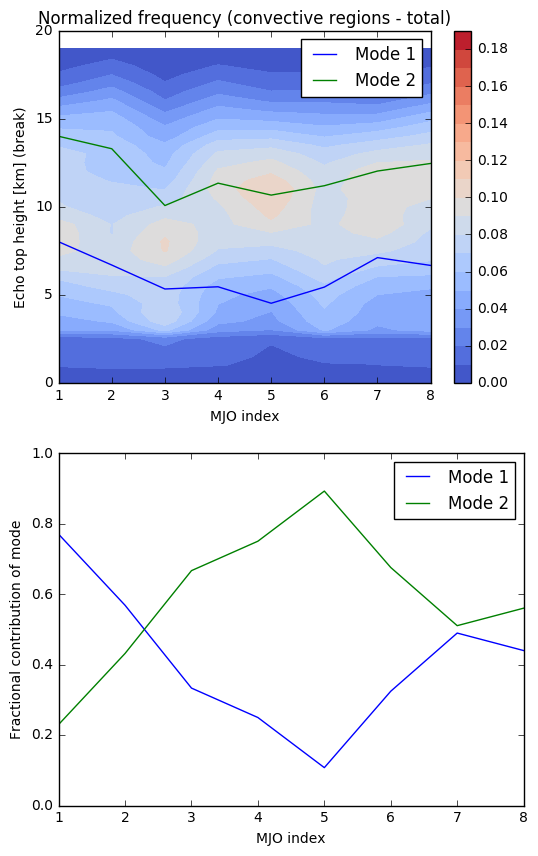

In [100]:
hist_mjo = hist_monsoon+hist_break
mjos_2d, bins_2d = np.meshgrid(np.arange(1,9), height_bins[:-1]/1e3)
five = np.zeros(8)
fifty = np.zeros(8)
ninety_five = np.zeros(8)
for mjo_index in range(0,8):
    five[mjo_index] = calc_percentile_from_hist(hist_monsoon[:,mjo_index],
                                                height_bins[:-1]/1e3,
                                                5)
    fifty[mjo_index] = calc_percentile_from_hist(hist_monsoon[:,mjo_index],
                                                 height_bins[:-1]/1e3,
                                                 50)
    ninety_five[mjo_index] = calc_percentile_from_hist(hist_monsoon[:,mjo_index],
                                                       height_bins[:-1]/1e3,
                                                       95)
plt.figure(figsize=(6,10))
plt.subplot(211)
plt.contourf(mjos_2d, bins_2d, hist_total/np.sum(hist_total, axis=0)*2,
             cmap='coolwarm', levels=np.arange(0,0.2,0.01))
#plt.plot(np.arange(1,9), five, color = 'k', linestyle='--')
#plt.plot(np.arange(1,9), fifty, color = 'k', linestyle='-')
#plt.plot(np.arange(1,9), ninety_five, color = 'k', linestyle='--')

plt.plot(np.arange(1,9), fits_total2[0,:], color='b', linestyle='-', label="Mode 1")
plt.plot(np.arange(1,9), fits_total2[2,:], color='g', linestyle='-', label="Mode 2")
#plt.plot(np.arange(1,9), fits_monsoon3[4,:], color='b', linestyle='-', label="3")
plt.legend(loc='best')
plt.xlabel('MJO index')
plt.ylabel('Echo top height [km] (break)')
plt.ylim([0,20])
plt.title('Normalized frequency (convective regions - total)')
ax = plt.colorbar()
plt.subplot(212)
plt.plot(np.arange(1,9), fits_total2[4,:], label="Mode 1", color='b')
plt.plot(np.arange(1,9), 1-fits_total2[4,:], label="Mode 2", color='g')
#plt.plot(np.arange(1,9), 1-np.sum(fits_monsoon3[6:8,:], axis=0), label="Deep", color='b')
plt.xlabel('MJO index')
plt.ylabel('Fractional contribution of mode')
plt.ylim([0, 1])
plt.legend(loc='best')

In [ ]:
hist_mjo = hist_total
mjos_2d, bins_2d = np.meshgrid(np.arange(1,9), height_bins[:-1]/1e3)
five = np.zeros(8)
fifty = np.zeros(8)
ninety_five = np.zeros(8)
for mjo_index in range(0,8):
    five[mjo_index] = calc_percentile_from_hist(hist_total[:,mjo_index],
                                                height_bins[:-1]/1e3,
                                                5)
    fifty[mjo_index] = calc_percentile_from_hist(hist_total[:,mjo_index],
                                                 height_bins[:-1]/1e3,
                                                 50)
    ninety_five[mjo_index] = calc_percentile_from_hist(hist_total[:,mjo_index],
                                                       height_bins[:-1]/1e3,
                                                       95)
plt.figure(figsize=(6,10))
plt.subplot(211)
plt.contourf(mjos_2d, bins_2d, hist_total/np.sum(hist_total, axis=0)*2,
             cmap='coolwarm', levels=np.arange(0,0.15,0.01))
#plt.plot(np.arange(1,9), five, color = 'k', linestyle='--')
#plt.plot(np.arange(1,9), fifty, color = 'k', linestyle='-')
#plt.plot(np.arange(1,9), ninety_five, color = 'k', linestyle='--')

plt.plot(np.arange(1,9), fits_total3[0,:], color='r', linestyle='-', label="1")
plt.plot(np.arange(1,9), fits_total3[2,:], color='g', linestyle='-', label="2")
plt.plot(np.arange(1,9), fits_total3[4,:], color='b', linestyle='-', label="3")
plt.legend(loc='best')
plt.xlabel('MJO index')
plt.ylabel('Echo top height [km] (break)')
plt.ylim([0,20])
plt.title('Normalized frequency (convective regions - total)')
ax = plt.colorbar()
plt.subplot(212)
plt.plot(np.arange(1,9), fits_total3[6,:], label="Shallow", color='r')
plt.plot(np.arange(1,9), fits_total3[7,:], label="Moderate", color='g')
plt.plot(np.arange(1,9), 1-np.sum(fits_total3[6:8,:], axis=0), label="Deep", color='b')
plt.xlabel('MJO index')
plt.ylabel('Fractional contribution of mode')
plt.ylim([0, 1])
plt.legend(loc='best')
print(fits_total3[6,:])

In [154]:
hist_break = hist2_file.variables['hist_break'][:]
hist_monsoon = hist2_file.variables['hist_monsoon'][:]
hist_total = hist2_file.variables['hist_total'][:]
hist_break[0,:] = 0
hist_monsoon[0,:] = 0
hist_total[0,:] = 0
hours = hist2_file.variables['hours'][:]

hist_break_mjoinactive = np.sum(hist_break[:,[0,1,2,7], :], axis=1)
hist_monsoon_mjoinactive = np.sum(hist_monsoon[:,[0,1,2,7], :], axis=1)
hist_total_mjoinactive = np.sum(hist_total[:,[0,1,2,7], :], axis=1)

hist_break_mjoactive = np.sum(hist_break[:,3:7, :], axis=1)
hist_monsoon_mjoactive = np.sum(hist_monsoon[:,3:7, :], axis=1)
hist_total_mjoactive = np.sum(hist_total[:,3:7, :], axis=1)

hist_break_mjoinactiven = np.zeros((39,24))
hist_monsoon_mjoinactiven = np.zeros((39,24))
hist_total_mjoinactiven = np.zeros((39,24))

hist_break_mjoactiven = np.zeros((39,24))
hist_monsoon_mjoactiven = np.zeros((39,24))
hist_total_mjoactiven = np.zeros((39,24))

hist_break_mjoinactivenalt = np.sum(hist_break[:,[0,1,2,7], :], axis=1)
hist_monsoon_mjoinactivenalt = np.sum(hist_monsoon[:,[0,1,2,7], :], axis=1)
hist_total_mjoinactivenalt = np.sum(hist_total[:,[0,1,2,7], :], axis=1)

hist_break_mjoactivenalt = np.sum(hist_break[:,3:7, :], axis=1)
hist_monsoon_mjoactivenalt = np.sum(hist_monsoon[:,3:7, :], axis=1)
hist_total_mjoactivenalt = np.sum(hist_total[:,3:7, :], axis=1)

fits_mjoactive2 = np.zeros((5,24))
fits_mjoinactive2 = np.zeros((5,24))
fits_mjoactive2u = np.zeros((2,24))
fits_mjoinactive2u = np.zeros((2,24))
fits_mjoactive2b = np.zeros((5,24))
fits_mjoinactive2b = np.zeros((5,24))
fits_mjoactive2m = np.zeros((5,24))
fits_mjoinactive2m = np.zeros((5,24))

guess = [3, 1, 15, 1, 0.5]
guess_u = [10, 1]
for i in range(24):
    hist_total_mjoactiven[:,i] = hist_monsoon_mjoactive[:,i]/np.sum(hist_monsoon_mjoactive[:,i])*2
    hist_total_mjoinactiven[:,i] = hist_monsoon_mjoinactive[:,i]/np.sum(hist_monsoon_mjoinactive[:,i])*2
    fits_mjoactive2[:,i], success = optimize.curve_fit(two_gaussians, p0=guess[:], 
                                                                  xdata=height_bins[:-1]/1e3, 
                                                                  ydata=hist_total_mjoactiven[:,i],
                                                                  bounds=(0,15))
    fits_mjoinactive2[:,i], success = optimize.curve_fit(two_gaussians, p0=guess[:], 
                                                                    xdata=height_bins[:-1]/1e3, 
                                                                    ydata=hist_total_mjoinactiven[:,i],
                                                                    bounds=(0,15))
    fits_mjoactive2u[:,i], success = optimize.curve_fit(gaussian, p0=guess_u[:], 
                                                                  xdata=height_bins[:-1]/1e3, 
                                                                  ydata=hist_total_mjoactiven[:,i],
                                                                  bounds=(0,15))
    fits_mjoinactive2u[:,i], success = optimize.curve_fit(gaussian, p0=guess_u[:], 
                                                                    xdata=height_bins[:-1]/1e3, 
                                                                    ydata=hist_total_mjoinactiven[:,i],
                                                                    bounds=(0,15))
sunrise = 21.5
sunset = 10.0

night_indicies = np.where(np.logical_and(hours >= sunset, hours < sunrise))
day_indicies = np.where(np.logical_or(hours <= sunset, hours >= sunrise))

hist_mjoactive2_night = np.sum(hist_break_mjoactive[:,night_indicies[0]], axis=1)
hist_mjoactive2_night = hist_mjoactive2_night/np.sum(hist_mjoactive2_night)
hist_mjoactive2_day = np.sum(hist_break_mjoactive[:,day_indicies[0]], axis=1)
hist_mjoactive2_day = hist_mjoactive2_day/np.sum(hist_mjoactive2_day)
hist_mjoinactive2_night = np.sum(hist_break_mjoinactive[:,night_indicies[0]], axis=1)
hist_mjoinactive2_night = hist_mjoinactive2_night/np.sum(hist_mjoinactive2_night)
hist_mjoinactive2_day = np.sum(hist_break_mjoinactive[:,day_indicies[0]], axis=1)
hist_mjoinactive2_day = hist_mjoinactive2_day/np.sum(hist_mjoinactive2_day)

(39,)


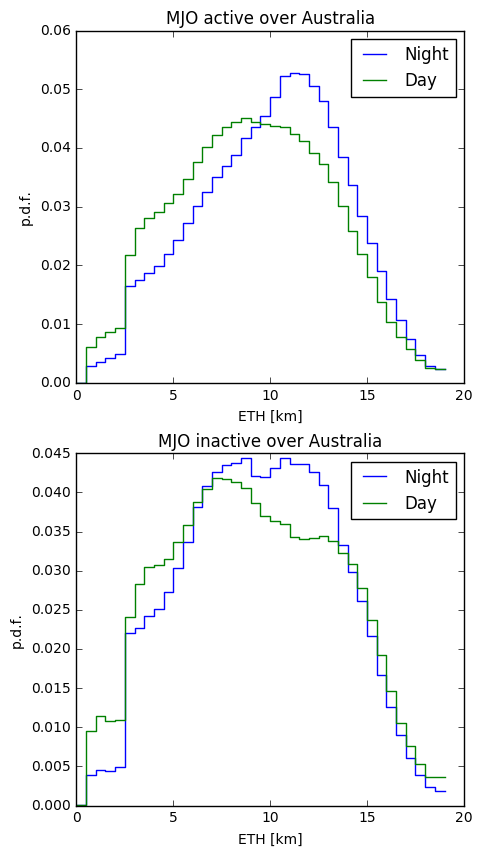

In [155]:
print(hist_mjoactive2_night.shape)
plt.figure(figsize=(5,10))
plt.subplot(211)
plt.step(height_bins[:-1]/1e3, hist_mjoactive2_night)
plt.step(height_bins[:-1]/1e3, hist_mjoactive2_day)
plt.legend(['Night', 'Day'])
plt.xlabel('ETH [km]')
plt.ylabel('p.d.f.')
plt.title('MJO active over Australia')

plt.subplot(212)
plt.step(height_bins[:-1]/1e3, hist_mjoinactive2_night)
plt.step(height_bins[:-1]/1e3, hist_mjoinactive2_day)
plt.legend(['Night', 'Day'])
plt.xlabel('ETH [km]')
plt.ylabel('p.d.f.')
plt.title('MJO inactive over Australia')

[[  4.01590568   8.08812182   7.34565471   8.49044936   8.85635682
    5.58480002   5.73078879   4.65508356   4.52705909   4.13766538
    4.34028327   3.54626925   9.63582336   4.0829304    8.68558832
    9.31552107   8.82561123   9.24925267   9.36036953   3.77293989
    3.46738953   6.29260739   4.51164183   3.94849805]
 [  0.98824546   3.31920443   2.84809597   3.26365169   3.58309626
    2.24624978   2.26898768   1.71563309   1.76899009   1.49313631
    1.60511776   0.76234646   3.79204387   1.12457398   3.92525999
    3.41053829   3.27873331   3.71855283   3.74190446   0.75925816
    0.58550631   2.69276682   1.44618975   0.80522415]
 [  9.67566786  13.35063984  12.33700717  13.72667449  13.34058395
   11.22968472  11.21302639  10.36857912  10.29838674   9.94252041
    9.92048463   9.49026601   9.88858945  10.4008126   10.58265942
   10.11898291  10.34315451   9.62393471   9.75215429   9.62449853
    9.81795234  11.50154202   9.46389009   9.14869272]
 [  3.70428085   1.69345197   2

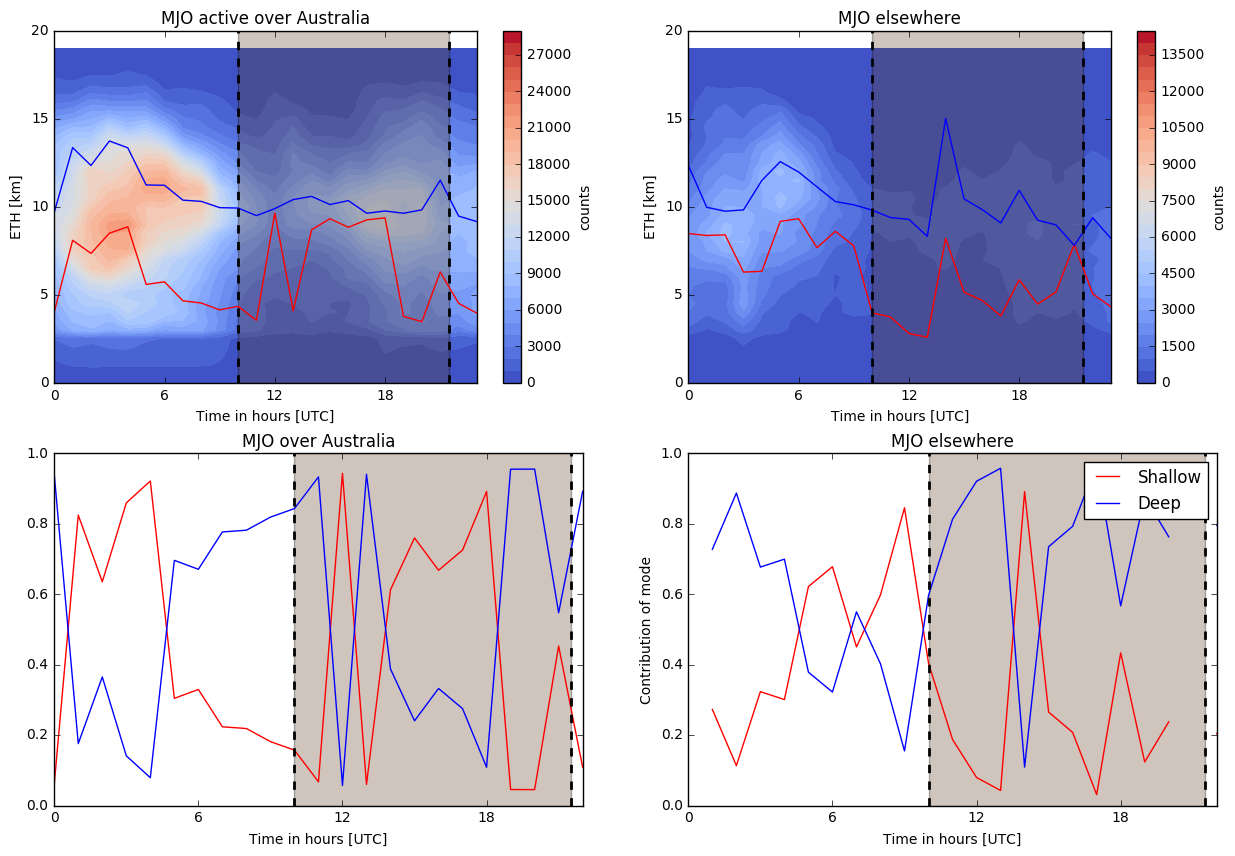

In [168]:
print(fits_mjoactive2)
contribution_mjoactive = fits_mjoactive2[4,:]
contribution_mjoactive = np.ma.masked_where(contribution_mjoactive > 1, contribution_mjoactive)
contribution_mjoinactive = fits_mjoinactive2[4,:]
contribution_mjoinactive = np.ma.masked_where(contribution_mjoinactive > 1, contribution_mjoinactive)

plt.figure(figsize=(15,10))
ax = plt.subplot(221)
hours_2d, bins_2d = np.meshgrid(hours, height_bins[:-1]/1e3)
plt.contourf(hours_2d, bins_2d, hist_monsoon_mjoactive, cmap='coolwarm', levels=np.arange(0,3e4, 1000))
plt.plot(np.arange(0,24), fits_mjoactive2[0, contribution_mjoactive > 0], color = 'r', linestyle='-', label="Mode 1")
plt.plot(np.arange(0,24), fits_mjoactive2[2, contribution_mjoactive > 0], color = 'b', linestyle='-', label="Mode 2")
plt.plot([21.5, 21.5], [0, 20], linewidth=2, color='k', linestyle='--')
plt.plot([10.0, 10.0], [0, 20], linewidth=2, color='k', linestyle='--')
my_plot = ax.fill_between([sunset,sunrise], 0, 20, interpolate=True, alpha=.3)
plt.setp(my_plot, facecolor='#614126')
plt.colorbar(label='counts')
plt.title('MJO active over Australia')
plt.xticks(range(0,24,6))
plt.xlabel('Time in hours [UTC]')
plt.ylabel('ETH [km]')

ax = plt.subplot(222)
hours_2d, bins_2d = np.meshgrid(hours, height_bins[:-1]/1e3)
plt.contourf(hours_2d, bins_2d, hist_monsoon_mjoinactive, cmap='coolwarm', levels=np.arange(0,1.5e4, 500))
plt.plot(np.arange(0,24), fits_mjoinactive2[0, contribution_mjoinactive > 0], color = 'r', linestyle='-', label="Mode 1")
plt.plot(np.arange(0,24), fits_mjoinactive2[2, contribution_mjoinactive > 0], color = 'b', linestyle='-', label="Mode 2")
plt.plot([21.5, 21.5], [0, 20], linewidth=2, color='k', linestyle='--')
plt.plot([10.0, 10.0], [0, 20], linewidth=2, color='k', linestyle='--')
my_plot = ax.fill_between([sunset,sunrise], 0, 20, interpolate=True, alpha=.3)
plt.setp(my_plot, facecolor='#614126')
plt.xticks(range(0,24,6))
plt.colorbar(label='counts')
plt.title('MJO elsewhere')
plt.xlabel('Time in hours [UTC]')
plt.ylabel('ETH [km]')

ax = plt.subplot(223)
plt.plot(np.arange(0,24), contribution_mjoactive, label="Mode 2", color='r')
plt.plot(np.arange(0,24), 1-contribution_mjoactive, label="Mode 1", color='b')
plt.plot([21.5, 21.5], [0, 1], linewidth=2, color='k', linestyle='--')
plt.plot([10.0, 10.0], [0, 1], linewidth=2, color='k', linestyle='--')
my_plot = ax.fill_between([sunset,sunrise], 0, 1, interpolate=True, alpha=.3)
plt.setp(my_plot, facecolor='#614126')
plt.xticks(range(0,24,6))
plt.xlabel('Time in hours [UTC]')
plt.xlim([0,22])
plt.title('MJO over Australia')


ax = plt.subplot(224)
plt.plot(np.arange(0,24), contribution_mjoinactive, label="Mode 2", color='r')
plt.plot(np.arange(0,24), 1-contribution_mjoinactive, label="Mode 1", color='b')
plt.plot([21.5, 21.5], [0, 1], linewidth=2, color='k', linestyle='--')
plt.plot([10.0, 10.0], [0, 1], linewidth=2, color='k', linestyle='--')
my_plot = ax.fill_between([sunset,sunrise], 0, 1, interpolate=True, alpha=.3)
plt.setp(my_plot, facecolor='#614126')
plt.xticks(range(0,24,6))
plt.xlabel('Time in hours [UTC]')
plt.xlim([0,22])
plt.ylabel('Contribution of mode')
plt.legend(['Shallow', 'Deep'])
plt.title('MJO elsewhere')

[[  5.12282918   8.48146858   8.367221     4.11494446   5.27295182
    6.7997669    5.22091052   5.90044092   6.1209969    9.00319777
    8.67645632   6.61524627]
 [  2.14925758   3.59263263   3.88284636   1.26556983   2.22104594
    2.94069427   2.05659343   2.22642727   2.42782434   3.52981037
    3.41727136   2.72216066]
 [ 10.58380866  13.49751379  13.97852801   9.69431642  11.3996233
   12.62184429  11.45940235  12.21167452  11.76069162  13.01160258
   13.18965892  12.37146863]
 [  3.1548       1.6361781    1.60805332   4.15344722   3.2111918
    2.63287662   2.93960044   2.82591179   2.55869457   2.68364715
    2.39742688   2.13602124]
 [  0.21558939   0.88097105   0.90536811   0.08414563   0.27189315
    0.43090597   0.18595692   0.27783788   0.27636456   0.68447739
    0.63056294   0.54363752]]


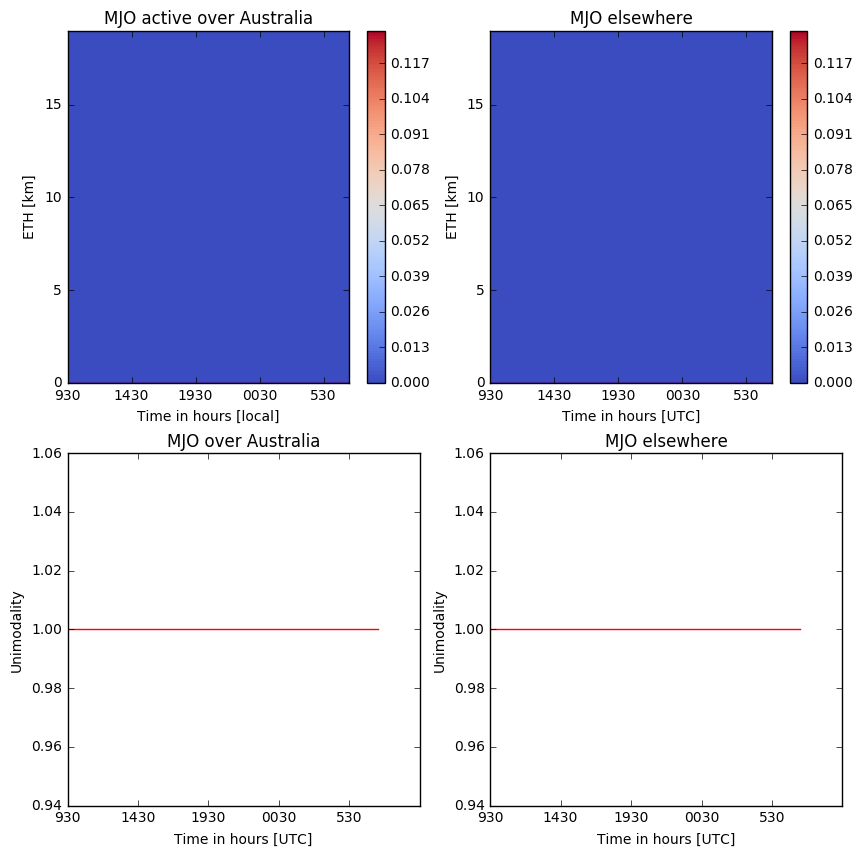

In [55]:
print(fits_mjoactive2)
plt.figure(figsize=(10,10))
ax = plt.subplot(221)
hours_2d, bins_2d = np.meshgrid(hours, height_bins[:-1]/1e3)
plt.contourf(hours_2d, bins_2d, hist_break_mjoactiven, cmap='coolwarm', levels=np.arange(0,0.13,0.001))
plt.plot(np.arange(0,24,2), fits_mjoactive2b[0,:], color = 'r', linestyle='-', label="Mode 1")
plt.plot(np.arange(0,24,2), fits_mjoactive2b[2,:], color = 'b', linestyle='-', label="Mode 2")
plt.colorbar()
plt.title('MJO active over Australia')
plt.xticks(range(0,24,5), ['930', '1430', '1930', '0030', '530'])
plt.xlabel('Time in hours [local]')
plt.ylabel('ETH [km]')

plt.subplot(222)
hours_2d, bins_2d = np.meshgrid(hours, height_bins[:-1]/1e3)
plt.contourf(hours_2d, bins_2d, hist_break_mjoinactiven, cmap='coolwarm', levels=np.arange(0,0.13,0.001))
plt.plot(np.arange(0,24,2), fits_mjoinactive2b[0,:], color = 'r', linestyle='-', label="Mode 1")
plt.plot(np.arange(0,24,2), fits_mjoinactive2b[2,:], color = 'b', linestyle='-', label="Mode 2")
plt.xticks(range(0,24,5), ['930', '1430', '1930', '0030', '530'])
plt.colorbar()
plt.title('MJO elsewhere')
plt.xlabel('Time in hours [UTC]')
plt.ylabel('ETH [km]')

plt.subplot(223)
plt.plot(np.arange(0,24,2), 2*np.abs(0.5-fits_mjoactive2b[4,:]), label="Mode 1", color='r')
plt.xticks(range(0,24,5), ['930', '1430', '1930', '0030', '530'])
plt.xlabel('Time in hours [UTC]')
plt.title('MJO over Australia')
plt.ylabel('Unimodality')

plt.subplot(224)
plt.plot(np.arange(0,24,2), 2*np.abs(0.5-fits_mjoinactive2b[4,:]), label="Mode 1", color='r')
plt.xticks(range(0,24,5), ['930', '1430', '1930', '0030', '530'])
plt.xlabel('Time in hours [UTC]')
plt.ylabel('Unimodality')
plt.title('MJO elsewhere')

[[  4.00515784   8.52594649   8.36269773   8.43180633   8.45366364
    4.57292784   4.21437137   4.24184751   4.3111252    4.44584655
    4.62859693   4.96788009   4.92464344   5.648568     5.67732184
    5.97995563   5.82084607   7.77618806   8.37285056   6.14564057
    8.13565319   8.43971464   8.50360935   6.97202806]
 [  0.96133589   3.48859053   3.42630101   3.45150346   3.76273063
    1.95538621   1.63282104   1.60478203   1.52400019   1.62274967
    1.81498458   1.96594912   2.0367152    2.4271285    2.28490199
    2.47566482   2.48276328   3.14388126   3.39067715   2.64402232
    3.31509178   3.46483834   3.52761438   2.90319605]
 [  9.60091538  13.34783462  13.47062471  13.78441701  13.94651275
   10.27363141  10.16113183  10.25237294  10.40624391  10.53578329
   10.91828973  11.19726597  11.02239073  11.5686365   11.87066151
   11.87288994  11.46537287  12.71005709  12.93749469  11.69380806
   12.85067714  13.18493896  13.17178602  11.95293503]
 [  3.70372665   1.73618504   1

/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


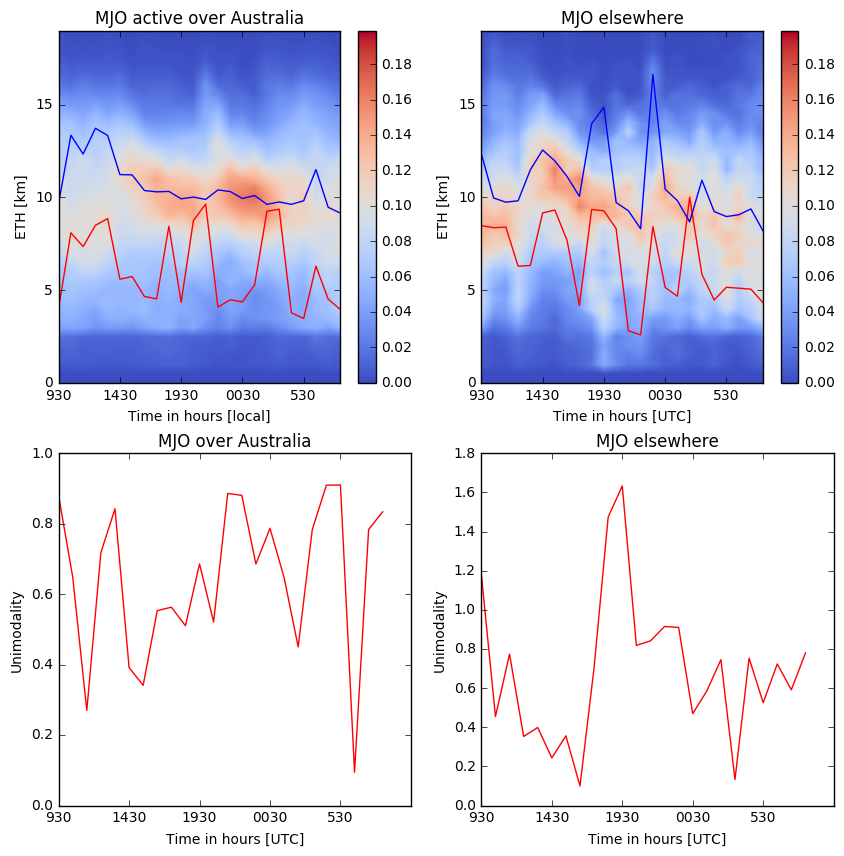

In [112]:
print(fits_mjoactive2)
plt.figure(figsize=(10,10))
ax = plt.subplot(221)
hours_2d, bins_2d = np.meshgrid(hours, height_bins[:-1]/1e3)
plt.contourf(hours_2d, bins_2d, hist_monsoon_mjoactiven, cmap='coolwarm', levels=np.arange(0,0.2,0.001))
plt.plot(np.arange(0,24), fits_mjoactive2m[0,:], color = 'r', linestyle='-', label="Mode 1")
plt.plot(np.arange(0,24), fits_mjoactive2m[2,:], color = 'b', linestyle='-', label="Mode 2")
plt.colorbar()
plt.title('MJO active over Australia')
plt.xticks(range(0,24,5), ['930', '1430', '1930', '0030', '530'])
plt.xlabel('Time in hours [local]')
plt.ylabel('ETH [km]')

plt.subplot(222)
hours_2d, bins_2d = np.meshgrid(hours, height_bins[:-1]/1e3)
plt.contourf(hours_2d, bins_2d, hist_monsoon_mjoinactiven, cmap='coolwarm', levels=np.arange(0,0.2,0.001))
plt.plot(np.arange(0,24), fits_mjoinactive2m[0,:], color = 'r', linestyle='-', label="Mode 1")
plt.plot(np.arange(0,24), fits_mjoinactive2m[2,:], color = 'b', linestyle='-', label="Mode 2")
plt.xticks(range(0,24,5), ['930', '1430', '1930', '0030', '530'])
plt.colorbar()
plt.title('MJO elsewhere')
plt.xlabel('Time in hours [UTC]')
plt.ylabel('ETH [km]')

plt.subplot(223)
plt.plot(np.arange(0,24), 2*np.abs(0.5-fits_mjoactive2m[4,:]), label="Mode 1", color='r')
plt.xticks(range(0,24,5), ['930', '1430', '1930', '0030', '530'])
plt.xlabel('Time in hours [UTC]')
plt.title('MJO over Australia')
plt.ylabel('Unimodality')

plt.subplot(224)
plt.plot(np.arange(0,24), 2*np.abs(0.5-fits_mjoinactive2m[4,:]), label="Mode 1", color='r')
plt.xticks(range(0,24,5), ['930', '1430', '1930', '0030', '530'])
plt.xlabel('Time in hours [UTC]')
plt.ylabel('Unimodality')
plt.title('MJO elsewhere')

/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


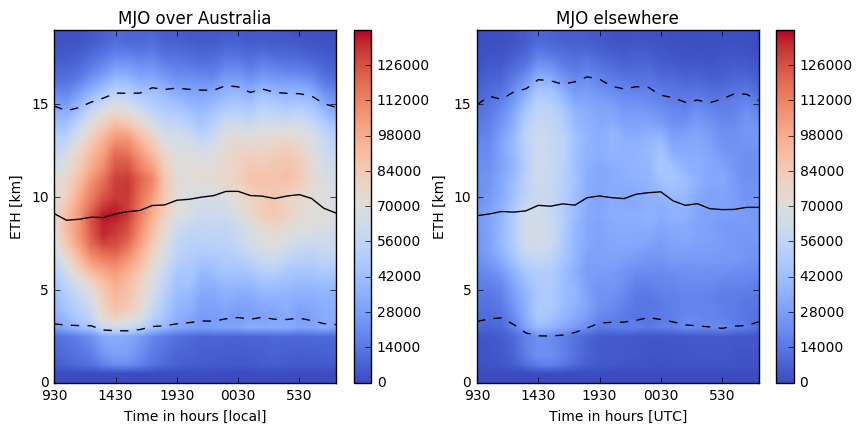

In [97]:
five_active = np.zeros(24)
fifty_active = np.zeros(24)
ninety_five_active = np.zeros(24)
five_inactive = np.zeros(24)
fifty_inactive = np.zeros(24)
ninety_five_inactive = np.zeros(24)

for mjo_index in range(0,24):
    five_active[mjo_index] = calc_percentile_from_hist(hist_total_mjoactive[:,mjo_index],
                                                height_bins[:-1]/1e3,
                                                5)
    fifty_active[mjo_index] = calc_percentile_from_hist(hist_total_mjoactive[:,mjo_index],
                                                 height_bins[:-1]/1e3,
                                                 50)
    ninety_five_active[mjo_index] = calc_percentile_from_hist(hist_total_mjoactive[:,mjo_index],
                                                       height_bins[:-1]/1e3,
                                                       95)
    five_inactive[mjo_index] = calc_percentile_from_hist(hist_total_mjoinactive[:,mjo_index],
                                                height_bins[:-1]/1e3,
                                                5)
    fifty_inactive[mjo_index] = calc_percentile_from_hist(hist_total_mjoinactive[:,mjo_index],
                                                 height_bins[:-1]/1e3,
                                                 50)
    ninety_five_inactive[mjo_index] = calc_percentile_from_hist(hist_total_mjoinactive[:,mjo_index],
                                                              height_bins[:-1]/1e3,
                                                              95)
plt.figure(figsize=(10,10))
ax = plt.subplot(221)
hours_2d, bins_2d = np.meshgrid(hours, height_bins[:-1]/1e3)
plt.contourf(hours_2d, bins_2d, hist_total_mjoactive, 
            cmap='coolwarm', levels=np.arange(0,140000,200))
plt.plot(np.arange(0,24), five_active, color='k', linestyle='--')
plt.plot(np.arange(0,24), fifty_active, color='k', linestyle='-')
plt.plot(np.arange(0,24), ninety_five_active, color='k', linestyle='--')
plt.colorbar()
plt.title('MJO over Australia')
plt.xticks(range(0,24,5), ['930', '1430', '1930', '0030', '530'])
plt.xlabel('Time in hours [local]')
plt.ylabel('ETH [km]')

plt.subplot(222)
hours_2d, bins_2d = np.meshgrid(hours, height_bins[:-1]/1e3)
plt.contourf(hours_2d, bins_2d, hist_total_mjoinactive, 
             cmap='coolwarm', levels=np.arange(0,140000,200))
plt.plot(np.arange(0,24), five_inactive, color='k', linestyle='--')
plt.plot(np.arange(0,24), fifty_inactive, color='k', linestyle='-')
plt.plot(np.arange(0,24), ninety_five_inactive, color='k', linestyle='--')
plt.xticks(range(0,24,5), ['930', '1430', '1930', '0030', '530'])
plt.colorbar()
plt.title('MJO elsewhere')
plt.xlabel('Time in hours [UTC]')
plt.ylabel('ETH [km]')

AttributeError: 'str' object has no attribute 'variables'

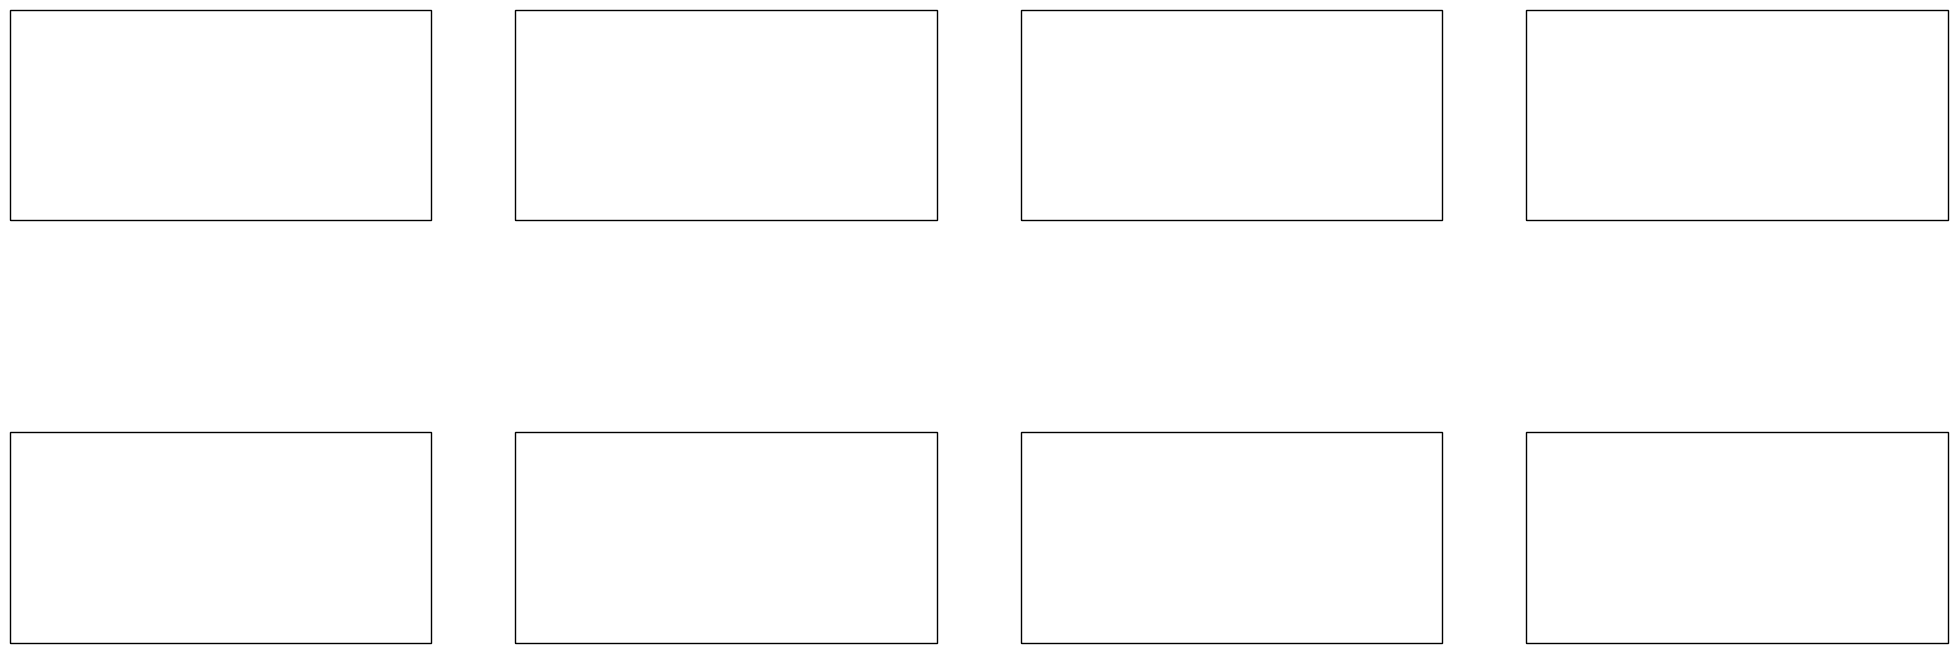

In [172]:
fig, ax = plt.subplots(2, 4, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(25,10))
the_netcdf = ('/home/rjackson/data/echo_top_spatial_histograms_time2_1_7.cdf')
print(the_netcdf.variables.keys())
latlon_cdf = Dataset(the_netcdf, mode='r')
hist_total = latlon_cdf['hist_break'][:]
lat = latlon_cdf['lat'][:]
lon = latlon_cdf['lon'][:]
# Degrade resolution by factor of x
x_factor = 1
lat = lat[::x_factor, ::x_factor]
lon = lon[::x_factor, ::x_factor]
new_hist = np.zeros((lat.shape[0], lat.shape[1],8))
for i in range(0, lat.shape[0]):
    for j in range(0, lat.shape[0]):
        for mjo in range(0,8):
            new_hist[i,j,mjo] = np.sum(hist_total[x_factor*i:x_factor*i+1,x_factor*j:x_factor*j+1,mjo])
        
for mjo_index in range(1,9):
    the_ind = int((mjo_index-1)/4)
    
    ax[the_ind, (mjo_index-1) % 4].coastlines(resolution='10m')
    ax[the_ind, (mjo_index-1) % 4].set_xticks([129, 130, 131, 132, 133], crs=ccrs.PlateCarree())
    ax[the_ind, (mjo_index-1) % 4].set_yticks([-14, -13.5, -13, -12.5, -12,
                                               -11.5, -11,-10.5,], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax[the_ind, (mjo_index-1) % 4].xaxis.set_major_formatter(lon_formatter)
    ax[the_ind, (mjo_index-1) % 4].yaxis.set_major_formatter(lat_formatter)
    the_hist = new_hist[:,:, mjo_index-1]
    the_hist = np.ma.masked_where(the_hist == 0, the_hist)
    the_plot = ax[the_ind, (mjo_index-1) % 4].pcolormesh(lon, lat, the_hist/np.sum(the_hist)*100, cmap='coolwarm',
                                                         vmin=0, vmax=0.02)
    plt.colorbar(the_plot, ax=ax[the_ind, (mjo_index-1) % 4])
    ax[the_ind, (mjo_index-1) % 4].set_xlim((130.0, 132.0))
    ax[the_ind, (mjo_index-1) % 4].set_ylim((-13.5, -11))
    ax[the_ind, (mjo_index-1) % 4].set_xticks([130.0, 130.5, 131.0, 131.5, 132])
    ax[the_ind, (mjo_index-1) % 4].set_yticks([-13.5, -13.0, -12.5, -12, -11.5, -11.0])
    ax[the_ind, (mjo_index-1) % 4].set_title('MJO index = ' + str(mjo_index))
print(lon.min(), lon.max())
print(lat.min(), lat.max())

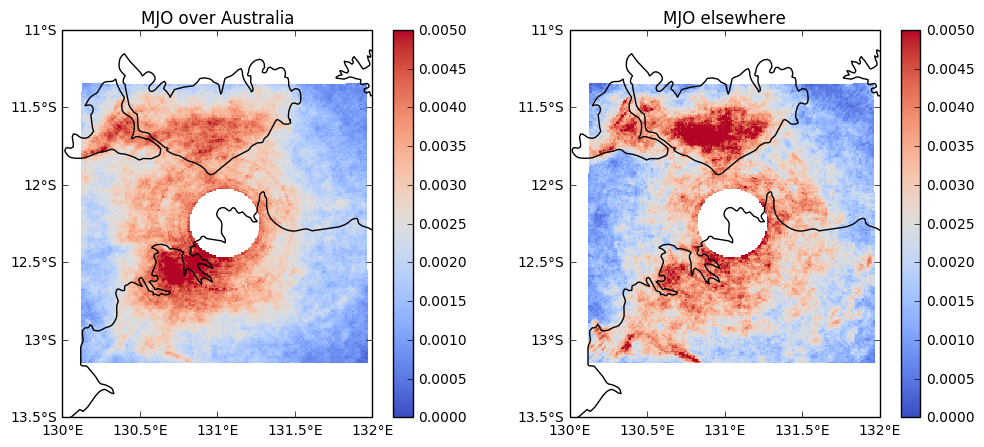

In [117]:
new_hist_4to7 = np.sum(new_hist[:,:,3:7], axis=2)
new_hist_else = np.sum(new_hist[:,:,1:3], axis=2) + new_hist[:,:,7]
fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(12,5))

    
ax[0].coastlines(resolution='10m')
ax[0].set_xticks([129, 130, 131, 132, 133], crs=ccrs.PlateCarree())
ax[0].set_yticks([-14, -13.5, -13, -12.5, -12, -11.5, -11,-10.5,], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax[0].xaxis.set_major_formatter(lon_formatter)
ax[0].yaxis.set_major_formatter(lat_formatter)
the_hist = new_hist_4to7
the_hist = np.ma.masked_where(the_hist == 0, the_hist)
the_plot = ax[0].pcolormesh(lon, lat, the_hist/np.sum(the_hist)*100, cmap='coolwarm',
                                                     vmin=0, vmax=0.005)
plt.colorbar(the_plot, ax=ax[0])
ax[0].set_xlim((130.0, 132.0))
ax[0].set_ylim((-13.5, -11))
ax[0].set_xticks([130.0, 130.5, 131.0, 131.5, 132])
ax[0].set_yticks([-13.5, -13.0, -12.5, -12, -11.5, -11.0])
ax[0].set_title('MJO over Australia')

ax[1].coastlines(resolution='10m')
ax[1].set_xticks([129, 130, 131, 132, 133], crs=ccrs.PlateCarree())
ax[1].set_yticks([-14, -13.5, -13, -12.5, -12, -11.5, -11,-10.5,], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax[1].xaxis.set_major_formatter(lon_formatter)
ax[1].yaxis.set_major_formatter(lat_formatter)
the_hist = new_hist_else
the_hist = np.ma.masked_where(the_hist == 0, the_hist)
the_plot = ax[1].pcolormesh(lon, lat, the_hist/np.sum(the_hist)*100, cmap='coolwarm',
                                                     vmin=0, vmax=0.005)
plt.colorbar(the_plot, ax=ax[1])
ax[1].set_xlim((130.0, 132.0))
ax[1].set_ylim((-13.5, -11))
ax[1].set_xticks([130.0, 130.5, 131.0, 131.5, 132])
ax[1].set_yticks([-13.5, -13.0, -12.5, -12, -11.5, -11.0])
ax[1].set_title('MJO elsewhere')

In [ ]:
the_netcdf = ('/home/rjackson/data/echo_top_histograms2.cdf')
Data = Dataset(the_netcdf)
print(Data.variables.keys())
years = Data['years'][:]
hist_total = Data['hist_total'][:]
height_bins = np.arange(0,19.5,0.5)

print(np.sum(hist_total[:,0,:], axis=1))
plt.step(height_bins, np.sum(hist_total[:,:,18], axis=1))